In [2]:
import random
import sys

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Lab 2 - Classification

## Data import

In [4]:
df = pd.read_csv("heart_failure.csv", delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## N/A handling

In [6]:
df.fillna(0)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Visualization

<AxesSubplot:>

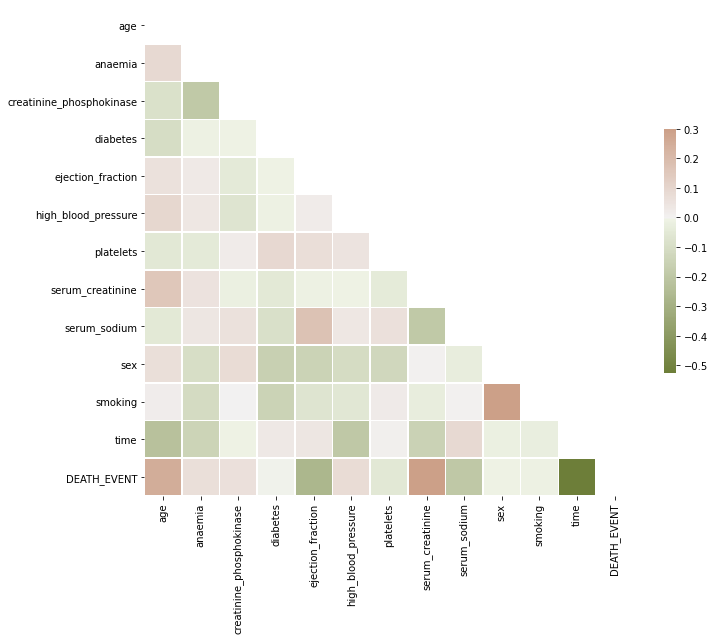

In [7]:
f, ax = plt.subplots(figsize=(11, 9))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 30, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

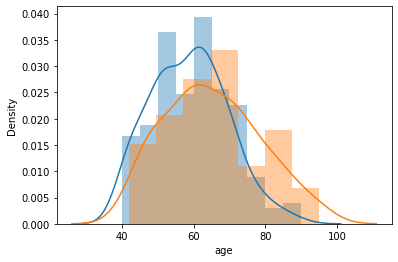

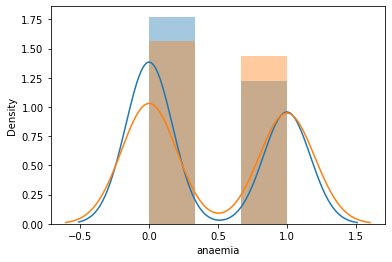

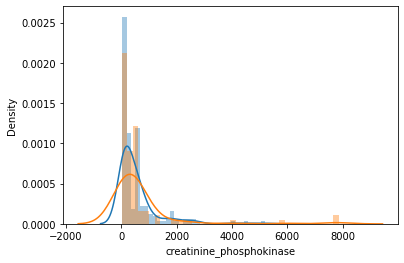

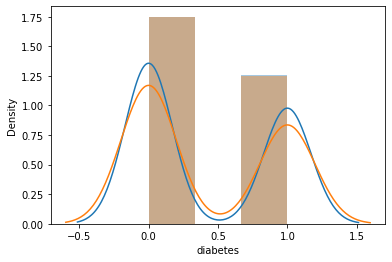

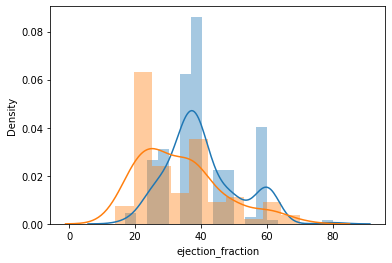

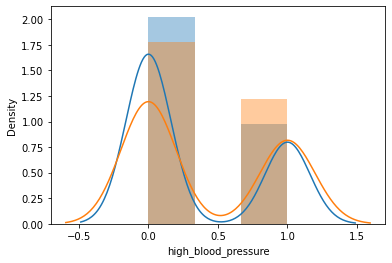

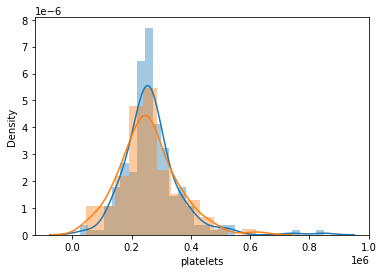

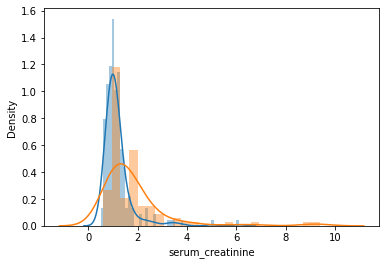

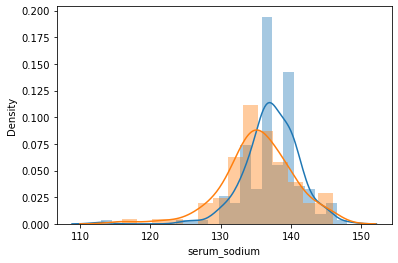

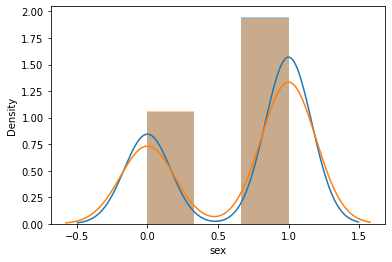

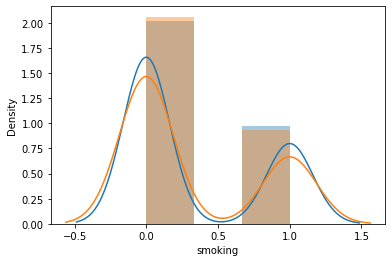

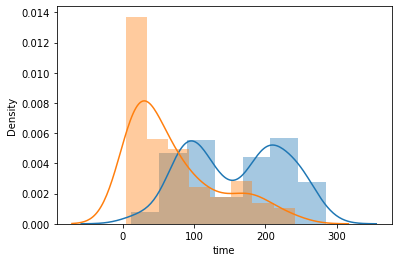

<Figure size 432x288 with 0 Axes>

In [10]:
import warnings
warnings.filterwarnings('ignore')

cols = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time','DEATH_EVENT']
for column in cols[:-1]:
    for i in [0,1]:
        
        x = df[column][df["DEATH_EVENT"] == i]
        sns.distplot(x)
    plt.figure()

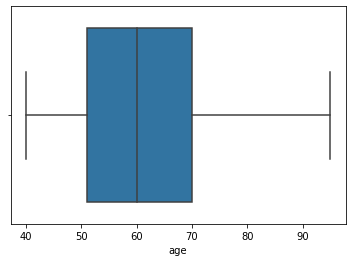

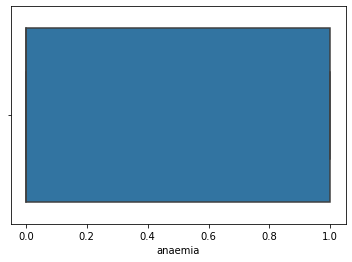

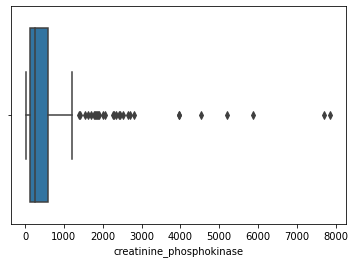

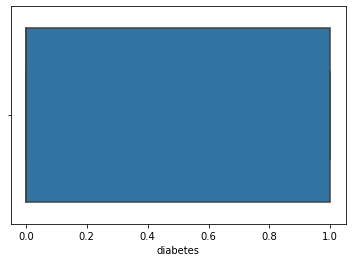

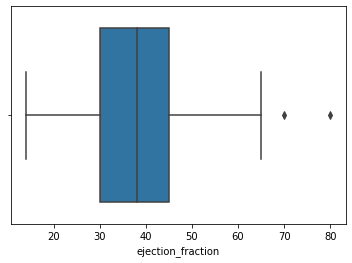

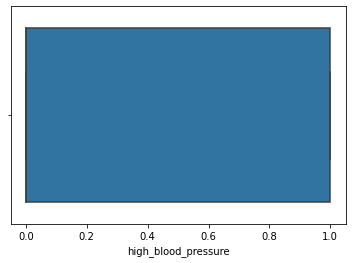

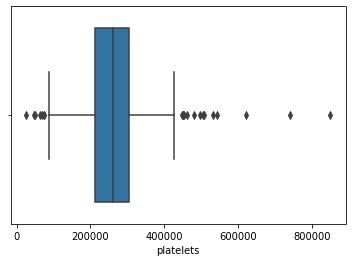

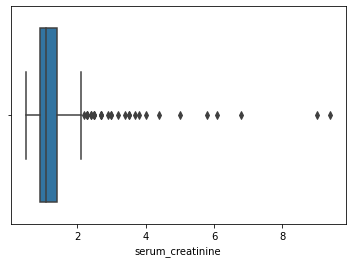

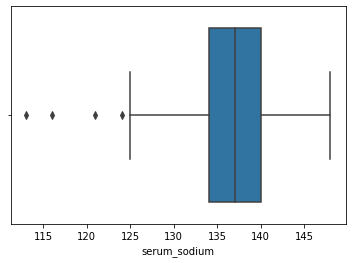

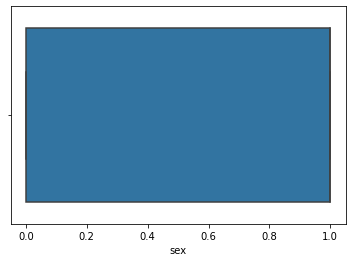

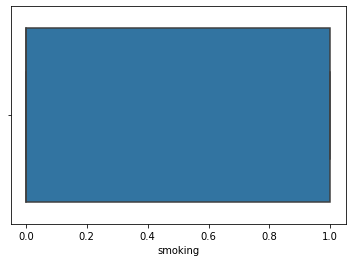

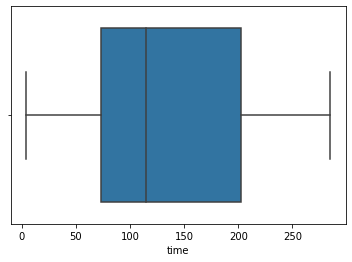

<Figure size 432x288 with 0 Axes>

In [11]:
for column in cols[:-1]:
    sns.boxplot(df[column])
    plt.figure()

### Normalization

In [12]:
for column in cols[:-1]:
    df[column] = (df[column] - df[column].mean())/df[column].std()

---

# Classification

In [13]:
Y = df.iloc[:, -1].values
X = df.iloc[:, :-1].values

num_samples = X.shape[0]
train_samples = int(0.8*num_samples)
indexes = np.arange(num_samples)
random.shuffle(indexes)

X, Y = X[indexes], Y[indexes]
X_train, Y_train = X[:train_samples, :], Y[:train_samples]
X_test, Y_test = X[train_samples:, :], Y[train_samples:]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(239, 12) (239,)
(60, 12) (60,)


### KNN - Classifier

<AxesSubplot:xlabel='k_neighbores', ylabel='f1_scores'>

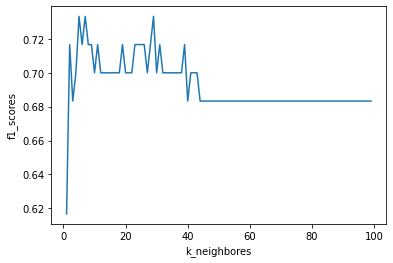

In [17]:
scores = list()
neighbors = list()

for i in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, Y_train)
    Y_predict = neigh.predict(X_test)
    _score = f1_score(Y_predict, Y_test, average="micro")
    scores.append(_score)
    neighbors.append(i)
    
df = pd.DataFrame({"f1_scores": scores, "k_neighbores": neighbors})
sns.lineplot(y="f1_scores", x="k_neighbores", data=df)

---

## Decision Tree - Classifier

In [19]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix SVC linear :")
print(confusion_matrix(Y_test, Y_predict))

target_names = ['class 0', 'class 1']

print("Classification report SVC linear :")
print(classification_report(Y_test, Y_predict, target_names=target_names))

Confusion matrix SVC linear :
[[36  5]
 [ 7 12]]
Classification report SVC linear :
              precision    recall  f1-score   support

     class 0       0.84      0.88      0.86        41
     class 1       0.71      0.63      0.67        19

    accuracy                           0.80        60
   macro avg       0.77      0.75      0.76        60
weighted avg       0.80      0.80      0.80        60



---

## Support Vector Machine - Classifier

### Linear

In [20]:
parameters = {'C': [1, 10, 100]}
neigh = SVC(kernel='linear')

clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix SVC linear :")
print(confusion_matrix(Y_test, Y_predict))

target_names = ['class 0', 'class 1']

print("Classification report SVC linear :")
print(classification_report(Y_test, Y_predict, target_names=target_names))
print(clf.best_params_)

Confusion matrix SVC linear :
[[39  2]
 [ 7 12]]
Classification report SVC linear :
              precision    recall  f1-score   support

     class 0       0.85      0.95      0.90        41
     class 1       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60

{'C': 10}


### RBF

In [21]:
parameters = {'C': [1, 10, 100], 'gamma': [0.001, 0.1, 1]}
neigh = SVC(kernel='rbf')

clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix SVC rbf :")
print(confusion_matrix(Y_test, Y_predict))

print("Classification report SVC linear :")
print(classification_report(Y_test, Y_predict, target_names=target_names))
print(clf.best_params_)

Confusion matrix SVC rbf :
[[38  3]
 [ 9 10]]
Classification report SVC linear :
              precision    recall  f1-score   support

     class 0       0.81      0.93      0.86        41
     class 1       0.77      0.53      0.62        19

    accuracy                           0.80        60
   macro avg       0.79      0.73      0.74        60
weighted avg       0.80      0.80      0.79        60

{'C': 100, 'gamma': 0.001}


---

# Ensemble

## Random forest

In [ ]:
parameters = {'n_estimators': [5, 10, 40, 50, 60, 80, 90]}
neigh = RandomForestClassifier()

clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix Random Forest :")
print(confusion_matrix(Y_test, Y_predict))

print("Classification report Random Forest :")
print(classification_report(Y_test, Y_predict, target_names=target_names))
print(clf.best_params_)

## Adaboost

In [23]:
parameters = {'n_estimators': [5, 10, 40, 50, 60, 80, 90], "learning_rate": [0.01, 0.1, 0.5, 1]}
neigh = AdaBoostClassifier()

clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix AdaBoost :")
print(confusion_matrix(Y_test, Y_predict))

print("Classification report AdaBoost :")
print(classification_report(Y_test, Y_predict, target_names=target_names))
print(clf.best_params_)

Confusion matrix AdaBoost :
[[  0   0   2   0   0   0]
 [  0   0   7   2   0   0]
 [  0   1 104  33   0   0]
 [  0   0  48  74   2   0]
 [  0   0   3  34   4   1]
 [  0   0   0   4   1   0]]
Classification report AdaBoost :
              precision    recall  f1-score   support

     class 3       0.00      0.00      0.00         2
     class 4       0.00      0.00      0.00         9
     class 5       0.63      0.75      0.69       138
     class 6       0.50      0.60      0.55       124
     class 7       0.57      0.10      0.16        42
     class 8       0.00      0.00      0.00         5

    accuracy                           0.57       320
   macro avg       0.28      0.24      0.23       320
weighted avg       0.54      0.57      0.53       320

{'learning_rate': 0.1, 'n_estimators': 80}


## Gradient boost

In [28]:
parameters = {'n_estimators': [5, 10, 40, 50, 60, 80, 90], "learning_rate": [0.01, 0.1, 0.5, 1]}
neigh = GradientBoostingClassifier()

clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, Y_train)

Y_predict = clf.predict(X_test)

print("Confusion matrix Gradient Boosting :")
print(confusion_matrix(Y_test, Y_predict))

print("Classification report Gradient Boosting :")
print(classification_report(Y_test, Y_predict, target_names=target_names))
print(clf.best_params_)

Confusion matrix Gradient Boosting :
[[  0   1   0   1   0   0]
 [  1   0   6   2   0   0]
 [  1   2 109  25   1   0]
 [  1   0  34  81   7   1]
 [  0   0   3  18  21   0]
 [  0   0   0   2   3   0]]
Classification report Gradient Boosting :
              precision    recall  f1-score   support

     class 3       0.00      0.00      0.00         2
     class 4       0.00      0.00      0.00         9
     class 5       0.72      0.79      0.75       138
     class 6       0.63      0.65      0.64       124
     class 7       0.66      0.50      0.57        42
     class 8       0.00      0.00      0.00         5

    accuracy                           0.66       320
   macro avg       0.33      0.32      0.33       320
weighted avg       0.64      0.66      0.65       320

{'learning_rate': 0.1, 'n_estimators': 80}
